 # An Employee Training Problem
This notebook is based on a problem posed in Chapter 8 of the AIMMS documentation:<br>
https://documentation.aimms.com/_downloads/AIMMS_modeling.pdf

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Problem Description:**<br>
Consider an airline company that needs to determine how many trainees to hire into their flight attendant program during the first 6 months of the year. Employees are hired at the beginning of each month. Newly hired employees need to go through 2 months of training during which time they are called trainees. After 2 months of training they will become flight attendants. Trainees can work up to 25 hours per month, while flight attendants can work up to 150 hours per month. Furthermore, the company can have up to 5 trainees at any given month. A flight attendant earns \\$5100 per month, while a trainee earns \\$3600 per month.
Each month a number of flight attendants resign, raising the need to hire new trainees. The personnel manager at this airline company needs to minimize the employee cost, while making sure there are enough flight attendants at each month.
At first, we assume the number of resignations in the next 6 months is known in advance, to make the problem easier. Furthermore, we know that the number of flight attendants at the beginning of December is 60, and there were no resignations in December. Also, 2 trainees were hired at the beginning of November, and 0 trainees were hired in December. The given information can be summarized as follows:

In [2]:
RR_df = pd.DataFrame()
RR_df["months"] = ["November", "December", "January", "February", "March", "April", "May", "June"]
RR_df["required_hours"] = [0, 0, 8000, 9000, 9800, 9900, 10050, 10500]
RR_df["resignations"] = [0, 0, 2, 0, 2, 0, 1, 0]

RR_df.head()

,months,required_hours,resignations
0,November,0,0
1,December,0,0
2,January,8000,2
3,February,9000,0
4,March,9800,2


In order to mathematically formulate the problem, we can use the following notation:<br>
**Parameters:**<br> 
c: monthly cost of one flight attendant,<br>
d: monthly cost of one trainee,<br>
u: monthly number of hours of one flight attendant,<br>
v: monthly number of hours of one trainee,<br>
m: maximum number of new trainees each month,<br>
$r_{t}$: required flight attendant hours in timestep t,<br>
$l_{t}$: number of flight attendants resigning in timestep t.<br>
**Variables:**<br>
$x_{t}$: number of flight attendants available in timestep t,<br>
$y_{t}$: number of trainees hired in timestep t.<br>
Given the above formulation, the Pyomo optimization problem can be summarized as follows:<br>
**Minimize:**
$$ 
\underset{}{min} \sum_{t}^{} cx_{t} + d(y_{t}+y_{t-1})
$$
**Subject to:**
$$
x_{t} = x_{t-1} - l_{t-1} + y_{t-2}
$$
$$
ux_{t} + \nu(y_{t} + y_{t-1}) \ge r_{t}
$$
$$
x_{t} \ge 0
$$
$$
0 \le y_{t} \le m
$$

In [4]:
model = ConcreteModel()

model.t = RangeSet(len(RR_df))

#Parameters
model.c = Param(initialize=5100,within=Reals)
model.d = Param(initialize=3600,within=Reals)
model.u = Param(initialize=150,within=Reals)
model.v = Param(initialize=25,within=Reals)
model.m = Param(initialize=5,within=Reals)

def fa_hours(model,t):
    return RR_df.loc[t-1,"required_hours"]
model.r = Param(model.t, initialize=fa_hours, within=NonNegativeIntegers)

def fa_resignation(model,t):
    return RR_df.loc[t-1,"resignations"]
model.l = Param(model.t, initialize=fa_resignation, within=NonNegativeIntegers)

#Variables
model.x = Var(model.t, within=NonNegativeIntegers)
model.y = Var(model.t, within=NonNegativeIntegers)

def fa_balance(model,t):
    if t<3:
        return Constraint.Skip
    else:
        return model.x[t] == model.x[t-1] - model.l[t-1] + model.y[t-2]
model.c1 = Constraint(model.t, rule=fa_balance)

def hours_balance(model,t):
    if t<3:
        return Constraint.Skip
    else:
        return model.u * model.x[t] + model.v * (model.y[t] + model.y[t-1]) >= model.r[t]
model.c2 = Constraint(model.t, rule=hours_balance)

def fa_count(model,t):
    if t==2:
        return model.x[t]==60
    else:
        return model.x[t] >= 0
model.c3 = Constraint(model.t, rule=fa_count)

def trainee_min_count(model,t):
    if t==1:
        return model.y[t] == 2
    elif t==2:
        return model.y[t] == 0
    else:
        return model.y[t] >= 0
model.c4 = Constraint(model.t, rule=trainee_min_count)

def trainee_max_count(model,t):
    return model.y[t] <= model.m
model.c5 = Constraint(model.t, rule=trainee_max_count)

def rule_OF(model):
    return sum(model.c * model.x[t] + model.d * (model.y[t]+model.y[t-1]) if t>2 else 0 for t in model.t)
model.objective = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('glpk')
results = opt.solve(model)

In [5]:
model.x.pprint()

x : Size=8, Index=t
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      1 :     0 :   0.0 :  None : False : False : NonNegativeIntegers
      2 :     0 :  60.0 :  None : False : False : NonNegativeIntegers
      3 :     0 :  62.0 :  None : False : False : NonNegativeIntegers
      4 :     0 :  60.0 :  None : False : False : NonNegativeIntegers
      5 :     0 :  65.0 :  None : False : False : NonNegativeIntegers
      6 :     0 :  65.0 :  None : False : False : NonNegativeIntegers
      7 :     0 :  67.0 :  None : False : False : NonNegativeIntegers
      8 :     0 :  70.0 :  None : False : False : NonNegativeIntegers


Text(0, 0.5, '# of trainees')

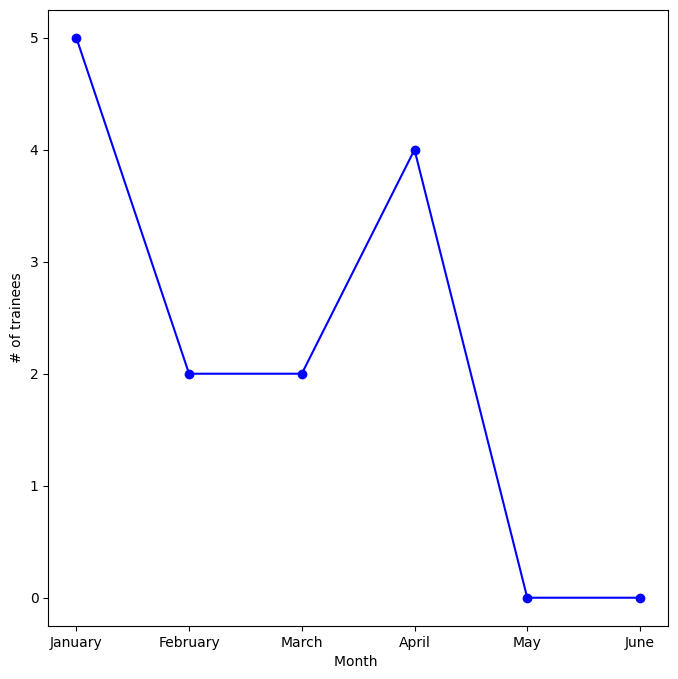

In [6]:
plt.figure(figsize=(8,8))
Y=[value(model.y[t]) for t in model.t]
X=[RR_df.loc[t-1,"months"] for t in model.t]
plt.plot(X[2:],Y[2:],'b-o')
plt.xlabel('Month ')
plt.ylabel('# of trainees')

 # Probabilistic Constraint
In the previous section, we assumed that the number of flight attendants that will resign is known for the first 6 months of the year. However, the number of resignations will likely be a random variable with its own distribution. We can assume it follows a normal distribution with means and variances given in the following table:

In [7]:
Resign_df = pd.DataFrame()
Resign_df["months"] = ["January", "February", "March", "April", "May", "June"]
Resign_df["mean"] = [1.15, 0.80, 1.30, 1.45, 0.85, 1.40]
Resign_df["variance"] = [0.57, 0.58, 0.73, 0.75, 0.50, 0.79]
Resign_df["alpha=0.01"] = [2.48, 2.15, 3.00, 3.19, 2.01, 3.24]
Resign_df["alpha=0.02"] = [2.32, 1.99, 2.80, 2.99, 1.88, 3.02]
Resign_df["alpha=0.05"] = [2.09, 1.75, 2.50, 2.68, 1.67, 2.70]

Resign_df

,months,mean,variance,alpha=0.01,alpha=0.02,alpha=0.05
0,January,1.15,0.57,2.48,2.32,2.09
1,February,0.80,0.58,2.15,1.99,1.75
2,March,1.30,0.73,3.00,2.80,2.50
3,April,1.45,0.75,3.19,2.99,2.68
4,May,0.85,0.50,2.01,1.88,1.67
5,June,1.40,0.79,3.24,3.02,2.70


Due to the fact that the number of resignations at each month is uncertain, the personnel manager needs to hire extra trainees every month in order to make sure all the flight requirements are met. Therefore, the flight attendant balance equation can be modified using the critical resignation numbers in the table above:
$$
PR[x_{t-1} + y_{t-2} - x_{t} \ge l_{t-1}] \ge 1-\alpha
$$
Or
$$
PR[x_{t-1} + y_{t-2} - x_{t} \le l_{t-1}] \le \alpha
$$
A very small value for α means that the probability of having enough trainees at each month to cover flight hours will be high. Now we can use the critical number of resignations at each month ($\overline{l}{t-1}$) in the optimization formulation as follows:<br>
**Minimize:**
$$ 
\underset{}{min} \sum{t}^{} cx_{t} + d(y_{t}+y_{t-1})
$$
**Subject to:**
$$
x_{t} \le x_{t-1} - \overline{l}{t-1} + y{t-2}
$$
$$
ux_{t} + \nu(y_{t} + y_{t-1}) \ge r_{t}
$$
$$
x_{t} \ge 0
$$
$$
0 \le y_{t} \le m
$$

In [9]:
del model

model = ConcreteModel()

model.t = RangeSet(len(RR_df))

#Parameters
model.c = Param(initialize=5100,within=Reals)
model.d = Param(initialize=3600,within=Reals)
model.u = Param(initialize=150,within=Reals)
model.v = Param(initialize=25,within=Reals)
model.m = Param(initialize=5,within=Reals)

def fa_hours(model,t):
    return RR_df.loc[t-1,"required_hours"]
model.r = Param(model.t, initialize=fa_hours, within=NonNegativeIntegers)

def fa_resignation(model,t):
    if t<3:
        return 0
    else:
        return Resign_df.loc[t-3,"alpha=0.01"]
model.l_hat = Param(model.t, initialize=fa_resignation, within=Reals)

#Variables
model.x = Var(model.t, within=NonNegativeIntegers)
model.y = Var(model.t, within=NonNegativeIntegers)

def fa_balance(model,t):
    if t<3:
        return Constraint.Skip
    else:
        return model.x[t] <= model.x[t-1] - model.l_hat[t-1] + model.y[t-2]
model.c1 = Constraint(model.t, rule=fa_balance)

def hours_balance(model,t):
    if t<3:
        return Constraint.Skip
    else:
        return model.u * model.x[t] + model.v * (model.y[t] + model.y[t-1]) >= model.r[t]
model.c2 = Constraint(model.t, rule=hours_balance)

def fa_count(model,t):
    if t==2:
        return model.x[t]==60
    else:
        return model.x[t] >= 0
model.c3 = Constraint(model.t, rule=fa_count)

def trainee_min_count(model,t):
    if t==1:
        return model.y[t] == 2
    elif t==2:
        return model.y[t] == 0
    else:
        return model.y[t] >= 0
model.c4 = Constraint(model.t, rule=trainee_min_count)

def trainee_max_count(model,t):
    return model.y[t] <= model.m
model.c5 = Constraint(model.t, rule=trainee_max_count)

def rule_OF(model):
    return sum(model.c * model.x[t] + model.d * (model.y[t]+model.y[t-1]) if t>2 else 0 for t in model.t)
model.objective = Objective(rule=rule_OF, sense=minimize)

opt = SolverFactory('ipopt')
# opt = SolverFactory('cbc')
results = opt.solve(model)

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.13\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


In [10]:
model.x.pprint()

x : Size=8, Index=t
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      1 :     0 :    99999.99999999 :  None : False : False : NonNegativeIntegers
      2 :     0 : 60.18408723183411 :  None : False : False : NonNegativeIntegers
      3 :     0 : 62.56272053047609 :  None : False : False : NonNegativeIntegers
      4 :     0 : 60.45867007113153 :  None : False : False : NonNegativeIntegers
      5 :     0 : 63.66666599666929 :  None : False : False : NonNegativeIntegers
      6 :     0 : 65.52527918000001 :  None : False : False : NonNegativeIntegers
      7 :     0 : 67.24292290795572 :  None : False : False : NonNegativeIntegers
      8 :     0 : 70.08304592539685 :  None : False : False : NonNegativeIntegers


Text(0, 0.5, '# of trainees')

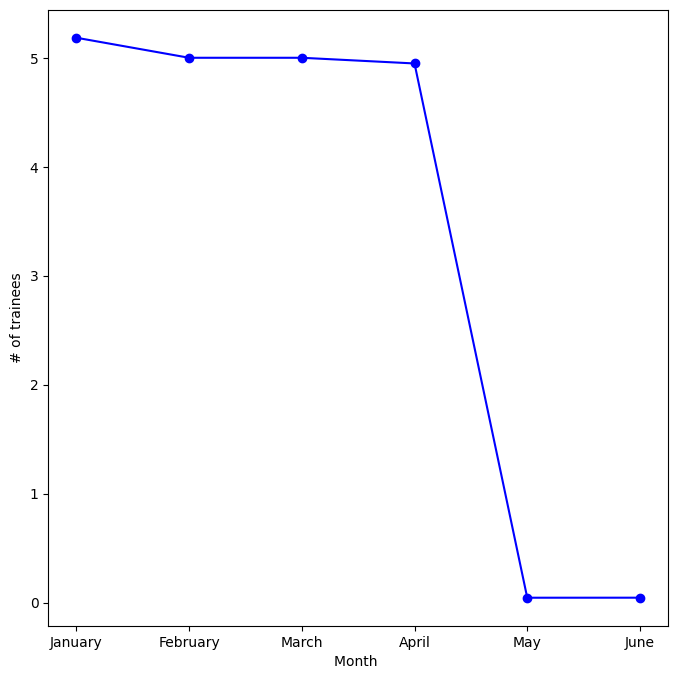

In [11]:
plt.figure(figsize=(8,8))
Y=[value(model.y[t]) for t in model.t]
X=[RR_df.loc[t-1,"months"] for t in model.t]
plt.plot(X[2:],Y[2:],'b-o')
plt.xlabel('Month ')
plt.ylabel('# of trainees')